# AI for Ethics
Final Project Summer 2020

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
!{sys.executable} -m pip install aif360
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install cvxpy
!{sys.executable} -m pip install tqdm

In [3]:
from aif360.datasets import BinaryLabelDataset
from aif360.datasets import CompasDataset

from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector

from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
            import load_preproc_data_compas
from aif360.algorithms.preprocessing.optim_preproc_helpers.distortion_functions\
            import get_distortion_compas
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_compas
from common_utils import compute_metrics

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

from IPython.display import Markdown, display


In [4]:
dataset = CompasDataset()

In [5]:
display(Markdown("### Reading Raw Compas Data"))
df = pd.read_csv(filepath_or_buffer='./compas-scores-two-years.csv')
print("Data shape (num_instances, num_features):", df.shape)
print("Features:", df.columns)

### Reading Raw Compas Data

Data shape (num_instances, num_features): (7214, 53)
Features: Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      dt

In [6]:
display(Markdown("### Measuring Fairness and Mitigating Bias for Race"))

privileged_groups = [{'race': 1}]
unprivileged_groups = [{'race': 0}]
dataset_orig = load_preproc_data_compas(['race'])

### Measuring Fairness and Mitigating Bias for Race

In [7]:
metric_orig = BinaryLabelDatasetMetric(dataset_orig, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig.mean_difference())

print("Difference in disparate impact between unprivileged and privileged groups = %f" % metric_orig.disparate_impact())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.132279
Difference in disparate impact between unprivileged and privileged groups = 0.782839


In [8]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf = RW.fit_transform(dataset_orig)

In [9]:
metric_transf = BinaryLabelDatasetMetric(dataset_transf, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

display(Markdown("#### Transformed training dataset using Reweighing"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf.mean_difference())

print("Difference in disparate impact between unprivileged and privileged groups = %f" % metric_transf.disparate_impact())

#### Transformed training dataset using Reweighing

Difference in mean outcomes between unprivileged and privileged groups = 0.000000
Difference in disparate impact between unprivileged and privileged groups = 1.000000


In [10]:
display(Markdown("### Measuring Fairness and Mitigating Bias for Sex"))

privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]
dataset_orig = load_preproc_data_compas(['sex'])

### Measuring Fairness and Mitigating Bias for Sex

In [11]:
metric_orig = BinaryLabelDatasetMetric(dataset_orig, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig.mean_difference())

print("Difference in disparate impact between unprivileged and privileged groups = %f" % metric_orig.disparate_impact())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.135037
Difference in disparate impact between unprivileged and privileged groups = 0.788415


In [12]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf = RW.fit_transform(dataset_orig)

In [13]:
metric_transf = BinaryLabelDatasetMetric(dataset_transf, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

display(Markdown("#### Transformed training dataset using Reweighing"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf.mean_difference())

print("Difference in disparate impact between unprivileged and privileged groups = %f" % metric_transf.disparate_impact())

#### Transformed training dataset using Reweighing

Difference in mean outcomes between unprivileged and privileged groups = 0.000000
Difference in disparate impact between unprivileged and privileged groups = 1.000000


In [14]:
display(Markdown("### Training a classifier to for original dataset"))

# Split into train, validation, and test
dataset_orig_train, dataset_orig_vt = dataset_orig.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True)

# Logistic regression classifier and predictions
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train)
y_train_pred = lmod.predict(X_train)

# positive class index
pos_ind = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train.copy()
dataset_orig_train_pred.labels = y_train_pred

### Training a classifier to for original dataset

In [15]:
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
X_valid = scale_orig.transform(dataset_orig_valid_pred.features)
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = lmod.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_orig.transform(dataset_orig_test_pred.features)
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [16]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                             dataset_orig_valid_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no fairness constraints) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no fairness constraints) = %.4f" % best_class_thresh)

Best balanced accuracy (no fairness constraints) = 0.6644
Optimal classification threshold (no fairness constraints) = 0.5445


In [17]:
display(Markdown("#### Predictions from original testing data"))

bal_acc_arr_orig = []
disp_imp_arr_orig = []
stat_parity_diff = []
avg_odds_diff_arr_orig = []

display(Markdown("#### Testing set"))
display(Markdown("##### Raw predictions - No fairness constraints"))

for thresh in tqdm(class_thresh_arr):
    
    fav_inds = dataset_orig_test_pred.scores > thresh
    dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
    dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label

    if (thresh == best_class_thresh):
        disp = True
    else:
        disp = False
        
    metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred, 
                                       unprivileged_groups, privileged_groups, disp=disp)
    
    bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])
    stat_parity_diff.append(metric_test_bef["Statistical parity difference"])

#### Predictions from original testing data

#### Testing set

##### Raw predictions - No fairness constraints

54%|█████▍    | 54/100 [00:00<00:00, 538.60it/s]Balanced accuracy = 0.6738
Statistical parity difference = -0.3345
Disparate impact = 0.5430
Average odds difference = -0.3097
Equal opportunity difference = -0.2266
Theil index = 0.2600
100%|██████████| 100/100 [00:00<00:00, 509.54it/s]


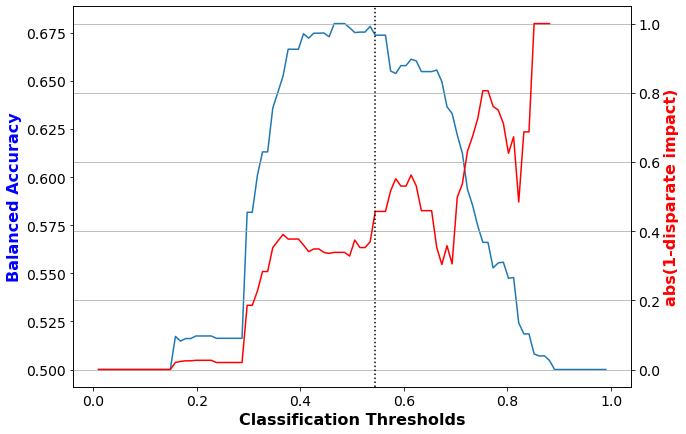

In [18]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_orig)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(np.array(class_thresh_arr)[best_ind], 
            color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

disp_imp_at_best_bal_acc_orig = np.abs(1.0-np.array(disp_imp_arr_orig))[best_ind]

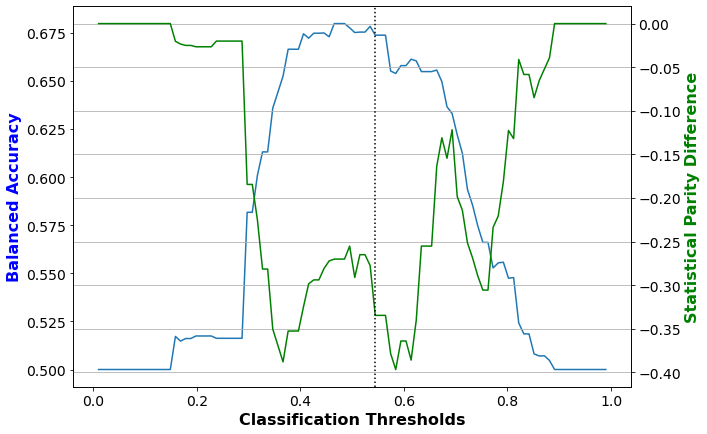

In [19]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, stat_parity_diff, color='g')
ax2.set_ylabel('Statistical Parity Difference', color='g', fontsize=16, fontweight='bold')
ax2.axvline(np.array(class_thresh_arr)[best_ind], 
            color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

In [20]:
display(Markdown("### Training a classifier to for transformed dataset"))
# Split into train, validation, and test
dataset_transf_train, dataset_transf_vt = dataset_transf.split([0.7], shuffle=True)
dataset_transf_valid, dataset_transf_test = dataset_transf_vt.split([0.5], shuffle=True)

scale_transf = StandardScaler()
X_train = scale_transf.fit_transform(dataset_transf_train.features)
y_train = dataset_transf_train.labels.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train)
y_train_pred = lmod.predict(X_train)

dataset_transf_train_pred = dataset_transf_train.copy()
dataset_transf_train_pred.labels = y_train_pred

### Training a classifier to for transformed dataset

In [21]:
dataset_transf_test_pred = dataset_transf_test.copy(deepcopy=True)
X_test = scale_transf.transform(dataset_transf_test_pred.features)
y_test = dataset_transf_test_pred.labels
dataset_transf_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [22]:
display(Markdown("#### Predictions from transformed testing data"))

bal_acc_arr_transf = []
disp_imp_arr_transf = []
disp_imp_arr_orig = []
avg_odds_diff_arr_transf = []

display(Markdown("#### Testing set"))
display(Markdown("##### Transformed predictions - No fairness constraints"))

for thresh in tqdm(class_thresh_arr):
    
    fav_inds = dataset_transf_test_pred.scores > thresh
    dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label

    if (thresh == best_class_thresh):
        disp = True
    else:
        disp = False
        
    metric_test_bef = compute_metrics(dataset_transf_test, dataset_transf_test_pred, 
                                       unprivileged_groups, privileged_groups, disp=disp)
    
    bal_acc_arr_transf.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_transf.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])
    disp_imp_arr_transf.append(metric_test_bef["Disparate impact"])

#### Predictions from transformed testing data

#### Testing set

##### Transformed predictions - No fairness constraints

100%|██████████| 100/100 [00:00<00:00, 313.31it/s]Balanced accuracy = 0.6220
Statistical parity difference = -0.2624
Disparate impact = 0.6202
Average odds difference = -0.2658
Equal opportunity difference = -0.2122
Theil index = 0.2825



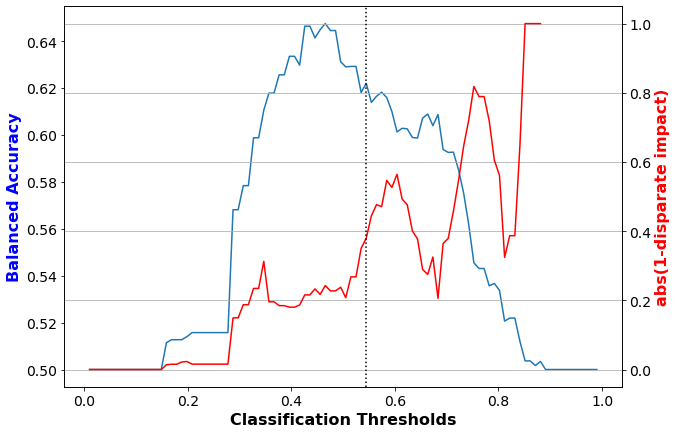

In [23]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_transf)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(np.array(class_thresh_arr)[best_ind], 
            color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

disp_imp_at_best_bal_acc_transf = np.abs(1.0-np.array(disp_imp_arr_transf))[best_ind]

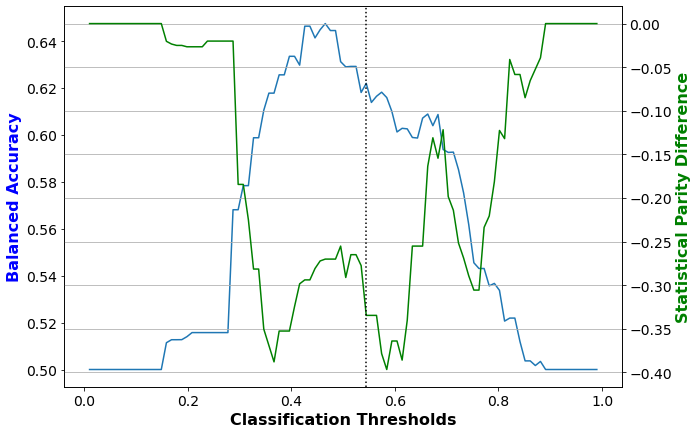

In [24]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, stat_parity_diff, color='g')
ax2.set_ylabel('Statistical Parity Difference', color='g', fontsize=16, fontweight='bold')
ax2.axvline(np.array(class_thresh_arr)[best_ind], 
            color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)